In [1]:
import healpy as hp
import numpy as np

import matplotlib.pyplot as plt

In [2]:
nSide = 256

# Main conclusions about the pixel window function

- When assigning galaxies to pixels, regardless of the clustering of the galaxies, the measured power matches the theory without correcting for the window function
- hp.ud_grade degrades a map by averaging the 4 neighboring pixels into one. This operation is not rigorously equivalent to a convolution with the pixel window function. When the power decreases fast, the hp.ud_grade operation is well approximated by a convolution with the window function. When the power is flat, it is well approximated by no convolution at all.

Big caveat: here I am assuming that assigning galaxies to pixels is the same as generating an independent Poisson variable in each pixel.
- In the first example, the mean is the same in all pixels.
- In the second, the mean varies per pixel, in a correlated way

# Poisson white noise

## Assigning galaxies to pixels

In [47]:
# nb of galaxies per sr
ngal = 1. * (180.*60./np.pi)**2 

# Poisson mean per pixel
lam = ngal * hp.nside2pixarea(nSide)

# Generate Poisson white noise
Ng = np.random.poisson(lam=lam, size=hp.nside2npix(nSide))

# Galaxy number overdensity
dg = 1.*Ng / np.mean(Ng) - 1.

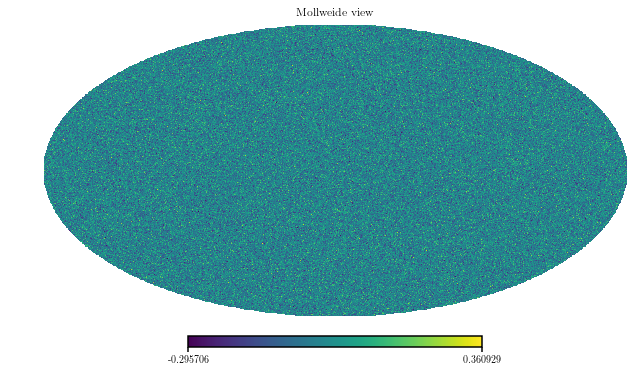

In [48]:
hp.mollview(dg)

In [49]:
cl = hp.anafast(dg)
ell = np.arange(len(cl))

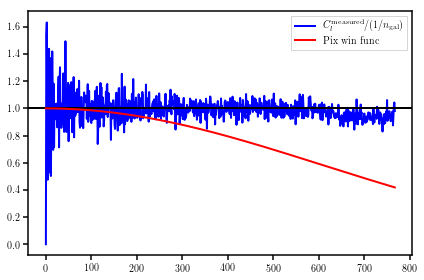

In [50]:
plt.plot(ell, cl / (1./ngal), 'b', label=r'$C_l^\text{measured} / (1/n_\text{gal})$')
plt.axhline(1., c='k')
plt.plot(ell, hp.pixwin(nSide)[:len(ell)]**2, 'r', label=r'Pix win func')
plt.legend()
plt.show()

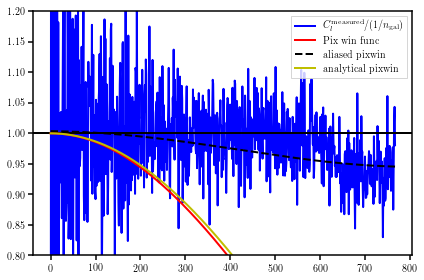

In [71]:
plt.plot(ell, cl / (1./ngal), 'b', label=r'$C_l^\text{measured} / (1/n_\text{gal})$')
plt.axhline(1., c='k')
plt.plot(ell, hp.pixwin(nSide)[:len(ell)]**2, 'r', label=r'Pix win func')

dtheta = hp.nside2resol(nSide)
f = lambda l: np.sinc(l * dtheta / (2.*np.pi)) * ()

lMax = 3.*nSide-1.
aliasedPixWin2 = f(ell)**2.# not aliased version
aliasedPixWin2 += f(2.*lMax-ell)**2 + f(6.*lMax - ell)**2 + f(8.*lMax - ell)**2# odd bounces
aliasedPixWin2 += f(ell + 2.*lMax)**2. + f(ell + 4.*lMax)**2 + f(ell + 6.*lMax)**2# even bounces
# aliasedPixWin2 = aliasedPixWin2**2
# I stopped when I got tired, but I feel like the series must converge 
# (as 1/n^2 because of the sinc^2)...
plt.plot(ell, aliasedPixWin2, 'k--', label=r'aliased pixwin')

anaPixWin2 = f(ell)**2
plt.plot(ell, anaPixWin2, 'y', label=r'analytical pixwin')


plt.legend()
plt.ylim((0.8, 1.2))
plt.show()



Here, we can see that the measured power spectrum matches the expectation of $1/n\text{gal}$ (blue curve matches 1).
There is a weird decrease in power at the highest $\ell$ (here nside=256), but much less than we would get if the map was convolved with the window function (red curve)

## Effect of hp.ud_grade

In [7]:
dg128 = hp.ud_grade(dg, 128)
cl128 = hp.anafast(dg128)
ell128 = np.arange(len(cl128))

In [8]:
ell.max(), 3*nSide-1

(767, 767)

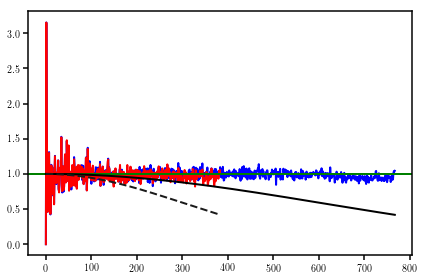

In [10]:
plt.plot(ell, cl * ngal, 'b')
plt.plot(ell128, cl128 * ngal, 'r')
plt.axhline(1., color='g')
# plt.plot(ell, np.ones_like(ell) / ngal)
plt.plot(ell, hp.pixwin(nSide)[:len(ell)]**2, 'k')


plt.plot(ell128, hp.pixwin(128)[:len(ell128)]**2, '--')
plt.show()

Degrading the map from blue to red truncated the power spectrum to lower ell, but did not convolve it with the window function (dashed line)

# Poisson sampling of a linear bias model

## Assigning galaxies to pixels

In [31]:
# Choose some arbitrary power spectrum, eg:
ell = np.arange(hp.nside2npix(nSide))
cl = 1. / (1. + ell)**(3.)

# Generate a Gaussian random field
grf = hp.synfast(cl, nSide)

# Fake matter overdensity field d:
# divide by field variance, to keep the fluctuations order unity
d = grf

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


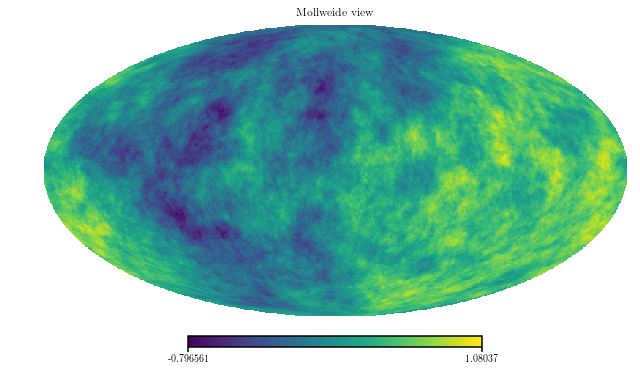

In [32]:
hp.mollview(d)

In [38]:
# do the Poisson sampling
# choose a high nb density, so shot noise does not dominate
ngal = 70000. * (180.*60./np.pi)**2 # per sr

# choose a small galaxy bias, so 1 + bg * d >0 everywhere
bg = 0.01

# Poisson mean per pixel
lam = ngal * hp.nside2pixarea(nSide) * (1 + bg * d)

# Poisson sampling
Ng = np.random.poisson(lam=lam, size=hp.nside2npix(nSide))

# galaxy number overdensity
dg = Ng / np.mean(Ng) - 1.

In [39]:
cl = hp.anafast(dg)
ell = np.arange(len(cl))

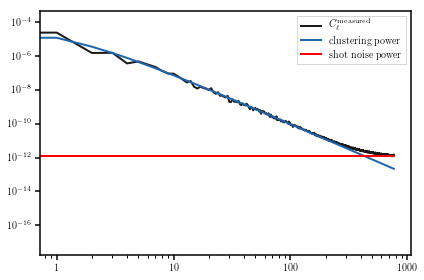

In [40]:
plt.loglog(ell, cl, label=r'$C_\ell^\text{measured}$')
plt.loglog(ell, bg**2 * 1./(1.+ell)**3, label=r'clustering power')
plt.loglog(ell, np.ones_like(ell) / ngal, 'r', label=r'shot noise power')
plt.legend()
plt.show()

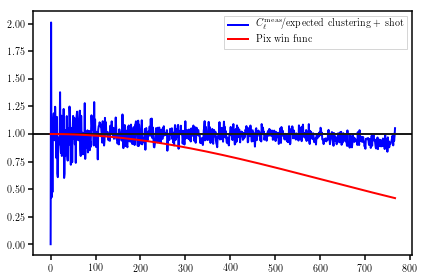

In [41]:
plt.plot(ell, cl / (bg**2 * 1./(1.+ell)**3 + 1./ngal), 'b', label=r'$C_\ell^\text{meas} / \text{expected clustering + shot}$')
plt.axhline(1.)
plt.plot(ell, hp.pixwin(nSide)[:len(ell)]**2, 'r', label=r'Pix win func')
plt.legend()
plt.show()


Again, even when the clustering power dominates the shot noise, the measured power matches the theory, without needing to correct for the pixel window function.

## Effect of hp.ud_grade

In [218]:
dg128 = hp.ud_grade(dg, 128)
cl128 = hp.anafast(dg128)
ell128 = np.arange(len(cl128))

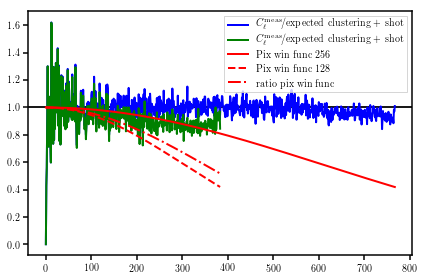

In [219]:
plt.axhline(1.)
plt.plot(ell, cl / (bg**2 * 1./(1.+ell)**2 + 1./ngal), 'b', label=r'$C_\ell^\text{meas} / \text{expected clustering + shot}$')
plt.plot(ell128, cl128 / (bg**2 * 1./(1.+ell128)**2 + 1./ngal), 'g', label=r'$C_\ell^\text{meas} / \text{expected clustering + shot}$')
plt.plot(ell, hp.pixwin(nSide)[:len(ell)]**2, 'r', label=r'Pix win func 256')
plt.plot(ell128, hp.pixwin(128)[:len(ell128)]**2, 'r--', label=r'Pix win func 128')

plt.plot(ell128, hp.pixwin(128)[:len(ell128)]**2 / hp.pixwin(nSide)[:len(ell128)]**2, 'r-.', label=r'ratio pix win func')
plt.legend()
plt.show()


Here, the power spectrum decreases with ell, and in this case the hp.ud_grade operation going from blue to green not only truncates the power spectrum, but it also decreases the power spectrum.
However, this decrease of power is not exactly equal to any window function, or ratio of window functions.
If the power spectrum decreases faster with ell, then it looks almost exactly like a convolution with the new pixel window function.